# Naive Bayes
### Modelo 12
- TfidfVectorizer
- Base B


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_b.csv')

df.head()

,nome,categoria
0,BRAHMA,BRAHMA
1,BRAHMA 550ML,BRAHMA
2,BRAHMA CERV 350ML LT,BRAHMA
3,BRAHMA CERVEJA 350ML,BRAHMA
4,BRAHMA CERVEJA 350ML LT,BRAHMA


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,BRAHMA,0
1,BRAHMA 550ML,0
2,BRAHMA CERV 350ML LT,0
3,BRAHMA CERVEJA 350ML,0
4,BRAHMA CERVEJA 350ML LT,0


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Lista de Stop Words

In [5]:
stopwords_arquivo = pd.read_csv('../../stopwords.csv')

lista_stop_words = [ token(word)[0] for word in stopwords_arquivo.stopwords.values ]

#### Separa base de treino e teste

In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome,
    df.categoria,
    test_size = 0.3,
    random_state = 42
)

#### Define TfidfVectorizer

In [7]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=token,
    ngram_range=(1,2),
    stop_words=lista_stop_words
)

#### Cria vocabulário

In [8]:
X_train = tfidf_vectorizer.fit_transform(X_train.values)

## Etapa de Treinamento
#### Cria um classificador Naive Bayes

In [9]:
model = GaussianNB()

#### Treina o classificador

In [10]:
model.fit(X_train.toarray(), y_train)

GaussianNB()

## Etapa de Teste

#### Efetua a predição

In [11]:
Y_Pred = model.predict(tfidf_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [12]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 81.2
precisao: 85.9


#### Tabela com os itens classificados errados na base de teste

In [13]:
d = []

for i in range(len(X_test)):
    au = tfidf_vectorizer.transform([X_test.values[i]])
    pred = model.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,GUARANA PET 600ML,GUARANA ANTARTICA,KUAT
1,SUCO DE UVA SPRES 2LT,SUCO UVA,SUCO LARANJA
2,REF LJA CINI,CINI REFRIGERANTE,FANTA
3,SUCO PRAT S LARANJA 900ML,SUCO LARANJA,SUCO LARANJA INTEGRAL
4,SUCO SU FRESH UVA 1L,SUCO UVA,SUCO LARANJA
...,...,...,...
164,SUCO INTEGRAL UVA 300ML,SUCO UVA INTEGRAL,SUCO LARANJA INTEGRAL
165,SUCO LARANJA M PR CP,SUCO LARANJA,SUCO LARANJA INTEGRAL
166,GUARANA 600 ML,GUARANA ANTARTICA,KUAT
167,SUCO LIFE LARANJA 2L,SUCO LARANJA,SUCO LARANJA INTEGRAL


#### Gráfico

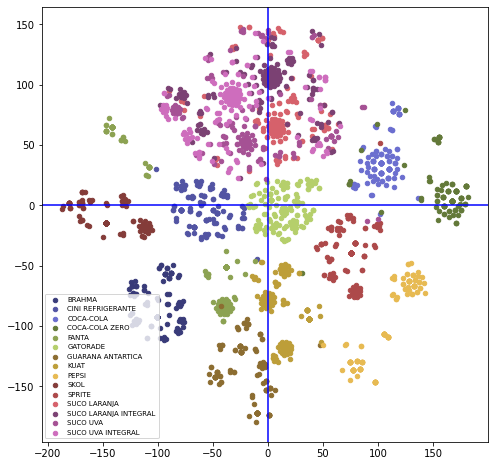

In [14]:
modelTSNE = TSNE(n_components=2, init='pca', random_state=0)
transformed = modelTSNE.fit_transform(X_train.todense())

fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], c=[plt.cm.tab20b(float(g)/15)], s=20, label = le.inverse_transform([g])[0])

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Matriz de Confusão

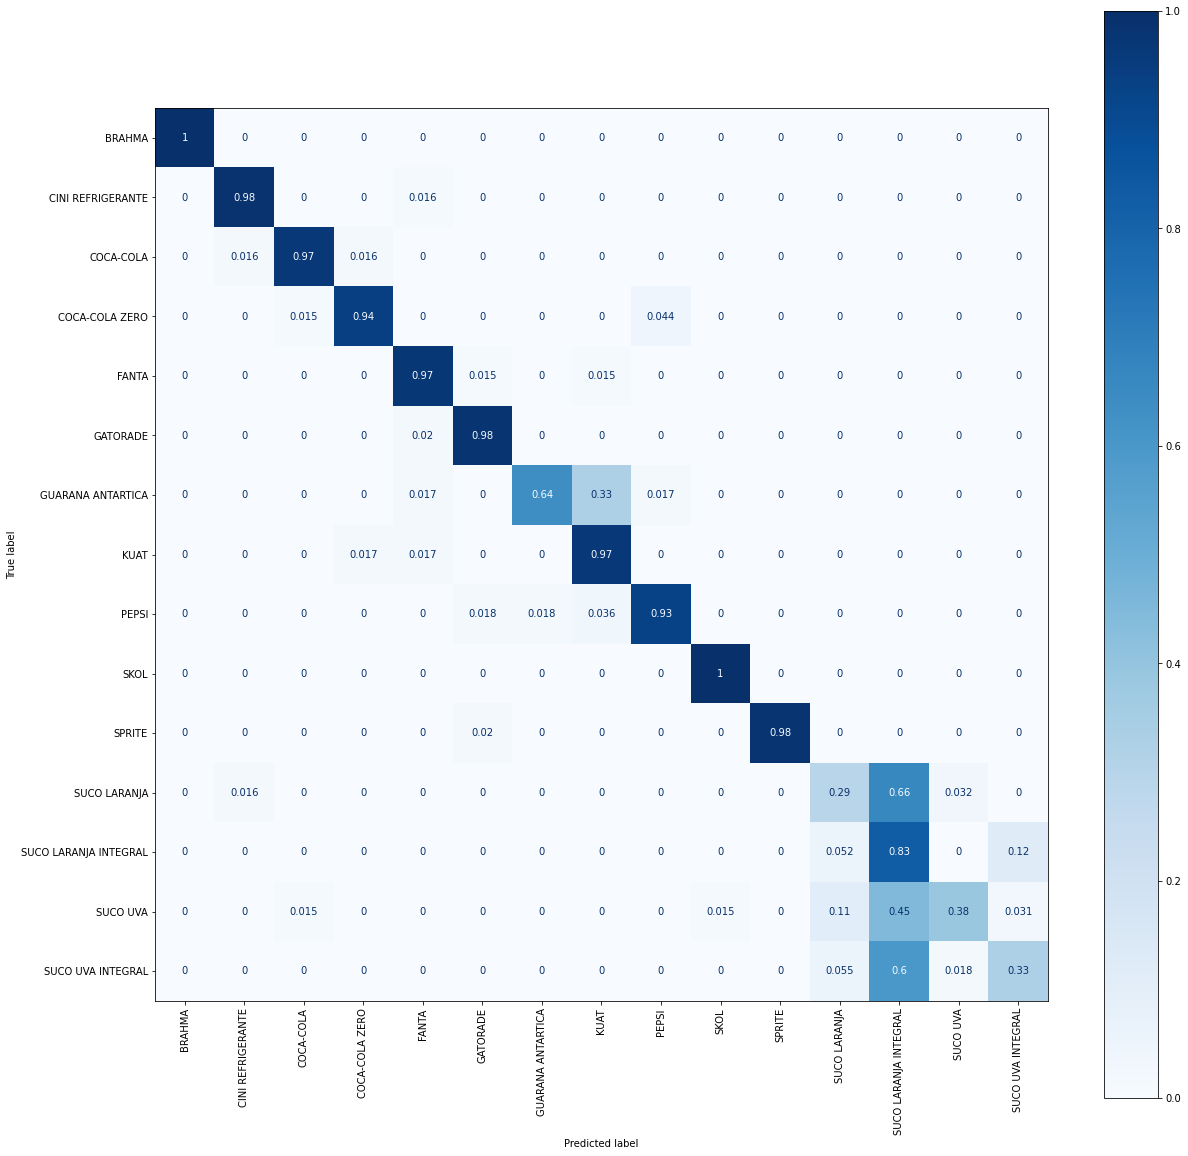

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(
    model,
    tfidf_vectorizer.transform(X_test).toarray(),
    y_test,
    display_labels=np.unique(le.inverse_transform(y_test)),
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax,
    xticks_rotation='vertical'
)